<a href="https://colab.research.google.com/github/Seung-heon-Baek/KSBi-BIML-2025/blob/main/%5BBIML2025%5DAdvanced_Deep_Learning_Models_for_Biomedical_Research_II_Practice_%EB%B0%B0%ED%8F%AC%EC%9A%A9v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIML 2025 Advanced Deep Learning Models for Biomedical Research
- 고려대학교 의과대학 전민지 교수, 심우종, 이지호 조교

### **실습에 앞서: WandB 가입**

WandB는 ML/DL 모델 실험을 편리하게 관리할 수 있는 MLOps 툴로, 모델 학습 과정에서 나오는 성능 metric을 시각화하고 체크포인트를 자동으로 저장하는 등의 기능을 갖추고 있습니다.  
이번 실습에서는 WandB를 이용해 scGPT fine-tuning 과정을 모니터링할 예정입니다.

WandB를 사용하기 위해서는 WandB 계정이 있어야 합니다. WandB를 처음 사용하시는 분들은 아래 링크에 접속하여 회원가입을 미리 진행해주시기 바랍니다.  
https://wandb.ai/site/ko/

### 실습 논문
- Cui, Haotian, et al. "scGPT: toward building a foundation model for single-cell multi-omics using generative AI." *Nature Methods* (2024)

### 실습을 위한 안내
- "`## 코드 시작 ##`", "`## 코드 종료 ##`"는 여러분이 직접 작성하시는 부분입니다.
- None으로 표기된 부분에 알맞은 코드를 대체합니다.

## 0. Colab 환경 설정
### 0.0 GPU 사용을 위한 설정
Colab에서 GPU를 사용하기 위해서 아래의 절차를 따라주시면 됩니다.  
`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU`로 설정 후 저장

### 0.1 필요한 라이브러리 설치
이번 실습에 사용되는 데이터를 다루고 코드를 실행하기 위해서는 `anndata`, `scanpy`, `scib` 라이브러리가 필요합니다.  
그러나 Colab에는 위 라이브러리가 설치되어있지 않기 때문에 아래 명령어를 실행하여 라이브러리를 직접 설치해줍니다.

In [ ]:
!pip install anndata scanpy scib

### 0.2 드라이브 마운트
개인 구글 드라이브와 Colab을 연결합니다.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


앞선 실습 시간에서 다운 받은 폴더 중 scGPT_practice.zip 파일에 사용할 데이터셋과 scGPT 소스코드가 저장되어 있습니다. 아래 코드 실행 시 이 zip 파일의 압축이 풀립니다.  
압축 해제 후 아래 구조로 데이터가 저장되어 있는지 확인해주세요.

- scGPT_dataset
    - celltype_cls
        - human_yolksac_train.h5ad
        - human_yolksac_test.h5ad
    - multiomics
        - BMMC_processed.h5ad
- scgpt
    - model
        - \_\_init\_\_.py
        - dsbn.py
        - grad_reverse.py
        - model.py
        - multiomic_model.py
        - args.json
        - vocab.json
        - best_model.pt
    - utils
        - \_\_init\_\_.py
        - loss.py
        - preprocess.py
        - tokenizer.py
        - trainer.py
        - utils.py
    - \_\_init\_\_.py

In [ ]:
import subprocess

# Google Drive 내 data.zip 파일의 절대 경로를 지정
target_file_path = "/content/drive/MyDrive/data.zip"

# data.zip 파일을 현재 위치에 압축 해제
command = ["unzip", "-qq", target_file_path, "-d", "./"]
subprocess.run(command)

CompletedProcess(args=['unzip', '-qq', '/content/drive/MyDrive/data.zip', '-d', './'], returncode=0)

In [ ]:
# Google Drive 내 scGPT_practice.zip 파일의 절대 경로를 지정
target_file_path = "/content/data/scGPT/scGPT_practice.zip"

# data.zip 파일을 현재 위치에 압축 해제
command = ["unzip", "-qq", target_file_path, "-d", "./"]
subprocess.run(command)

CompletedProcess(args=['unzip', '-qq', '/content/data/scGPT/scGPT_practice.zip', '-d', './'], returncode=0)

### 0.3 필요한 패키지 불러오기

In [ ]:
import copy
import gc
import json
import os
import sys
import time
import traceback
import warnings
from typing import Iterable, List, Tuple, Dict, Sequence, Optional, Callable
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scipy.sparse as sp
from scipy.sparse import issparse
import umap
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from anndata import AnnData
import scanpy as sc

from scgpt import logger
from scgpt.utils.preprocess import Preprocessor
from scgpt.utils.tokenizer import Vocab, tokenize_and_pad_batch, random_mask_value
from scgpt.model.model import TransformerModel, AdversarialDiscriminator
from scgpt.model.multiomic_model import MultiOmicTransformerModel
from scgpt.utils.trainer import SeqDataset, prepare_data, define_wandb_metrics, train, evaluate, eval_testdata
from scgpt.utils.utils import set_seed, add_file_handler
from scgpt.utils.trainer import SubsetsBatchSampler

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

아래 코드 실행 시 `GPU 사용 가능 여부: False`로 출력되면 GPU 런타임으로 연결해주세요.  
`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU`로 설정 후 저장

In [ ]:
print(f"GPU 사용 가능 여부: {torch.cuda.is_available()}")

# 실습 1. Cell type annotation

실습 목표: scRNA-seq 데이터셋으로 cell type 예측하기, **모델 fine-tuning 전후로 cell embedding clustering 결과와 cell type annotation 성능 비교하기**

차례
1. 하이퍼파라미터 세팅
1. 데이터 불러오기 및 전처리
1. 사전학습 된 scGPT 모델 사용하기
1. scGPT fine-tuning하기

## 1. 하이퍼파라미터 세팅

하이퍼파라미터는 학습되는 파라미터가 아닌, 사용자가 직접 설정해 주어야 하는 값들을 의미합니다.

| 이름                 | Type                     | 설명                                                                       
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `seed`            | `int`                    | 모델 초기화 시드                                              |
| `do_train`           | `bool`                    | 학습을 통해 모델의 파라미터 업데이트 여부                                                                 |
| `load_model`              | `str`                    | 사전학습된 모델의 파라미터가 들어있는 모델 경로                                                       |
| `GEP`               | `bool`                    | Fine-tuning objective 1: gene expression prediction 여부                                             |
| `GEPC`              | `bool`                    | Fine-tuning objective 2: GEP for cell modeling 여부                                                             |
| `CLS`                | `bool`                    | Fine-tuning objective 3: cell type classification 여부                                                 |
| `ESC`              | `bool`                  | Fine-tuning objective 4: elastic cell similarity 여부                     |
| `DAR`         | `bool`                    | Fine-tuning objective 5: domain adaptation via reverse back propagation 여부                                                   |
| `DSBN`           | `bool`                    | Fine-tuning objective 6: domain-specific batch normalization 여부                                                   |
| `ecs_thres`            | `float \| int`                    | ECS task에서의 similarity threshold, ECS 미수행 시 0                                                 |
| `dab_weight`           | `float \| int`                    | Domain adaptation loss 비율                                                                 |
| `use_batch_labels`          | `bool`                   | Batch embedding 사용 여부                                                  |
| `use_mod`               | `bool` | Modality token 사용 여부, multi-modality input 사용 시 True                                            |
| `mask_ratio` | `float`                   | MLM에서 masking 비율                                                         |
| `explicit_zero_prob` | `bool`                   | 확률적으로 특정 gene에 대한 발현량을 0으로 맞춰줄 것인지 여부                                                         |
| `per_seq_batch_sample` | `bool`                   | 모델 학습을 위한 mini-batch를 만들 때, 한 mini-batch에는 같은 scRNA-seq batch로부터 나온 데이터로만 구성할지 여부                                                         |
| `epochs` | `int`                   | Training epoch 수                                                         |
| `input_layer_key` | `str`                   | AnnData 객체의 layer 중 model input으로 사용할 layer                                                         |
| `n_bins` | `int`                   | Value binning 기법에서 사용할 bin 수                                                         |
| `n_hvg` | `int` | 원본 데이터 중 HVG 몇 개만 선별하여 사용할 지 설정 |
| `max_seq_len` | `int` | Default n_hvg + 1 |
| `lr` | `float` | 학습률 |
| `batch_size` | `int` | Mini-batch 크기 |
| `layer_size` | `int` | Embedding vector의 dimension 수 |
| `nlayers` | `int` | Transformer 모델의 encoder layer 수 |
| `nhead` | `int` | Multi-head attention에서 사용할 head 수 |
| `dropout` | `float` | MLP에 적용할 dropout 비율 |
| `schedule_ratio` | `float` | 학습률 scheduler에 사용할 learning rate decay 비율 |
| `save_eval_interval` | `int` | 몇 epoch마다 학습된 파라미터를 파일로 저장할지 지정 |
| `log_interval` | `int` | 학습 상황 logging을 몇 mini-batch마다 할 것인지 지정 |
| `fast_transformer` | `bool` | FlashAttention 사용 여부 |
| `pre_norm` | `bool` | LayerNorm을 self-attention 및 feed-forward 모듈 전에 적용할 것인지 여부 |
| `amp` | `bool` | Mixed precision learning 적용 여부, 사용 시 연산 효율성과 학습 성능을 향상 |
| `pad_token` | `str` | Vocab에 pad token이 어떻게 저장되어있는지 작성 |
| `mask_value` | `int` | Mask token index |
| `pad_value` | `int` | Pad token index |
| `include_zero_gene` | `bool` | 발현량이 0인 gene도 포함할지 여부 |
| `freeze` | `bool` | Fine-tuning 시 인코더 freeze 여부 |

In [ ]:
hyperparameters = {
    "task": "annotation",
    "seed": 42,
    "dataset_name": "human_yolksac",
    "do_train": True,
    "load_model": "./scgpt/model",
    ## 코드 시작 ##
    ## 아래 fine-tuning objective (GEP-DSBN) 중 이번 실습에서 사용할 objective를 boolean으로 표시해주세요.
    ## None 대신 각 기준에 올바른 값들을 넣어주세요
    "GEP": None,
    "GEPC": None,
    "CLS": None,
    "ESC": None,
    "DAR": None,
    "DSBN": None,
    "mask_ratio": None, # GEP 및 GEPC가 fine-tuning objective인 경우 mask ratio를 0.4로 지정해주고, objective가 아닌 경우 0으로 설정
    "ecs_thres": None, # ECS가 fine-tuning objective인 경우 cell similarity threshold를 0.8로 지정해주고, objective가 아닌 경우 0으로 설정
    "dab_weight": None, # DAR이 fine-tuning objective인 경우 domain adaptation loss 적용 비율을 1.0으로 지정해주고, objective가 아닌 경우 0으로 설정
    "use_batch_labels": None,
    "use_mod": None,
    ## 코드 종료 ##
    "explicit_zero_prob": False,
    "per_seq_batch_sample": False,
    "epochs": 2,
    "input_layer_key": "X_binned",
    "n_bins": 51,
    "max_seq_len": 3001,
    "lr": 1e-4,
    "batch_size": 32,
    "layer_size": 512,
    "nlayers": 4,
    "nhead": 8,
    "dropout": 0.2,
    "schedule_ratio": 0.9,
    "save_eval_interval": 5,
    "log_interval": 100,
    "fast_transformer": False,
    "pre_norm": False,
    "amp": True,
    "pad_token": "<pad>",
    "mask_value": -1,
    "pad_value": -2,
    "include_zero_gene": False,
    "freeze": True
}

설정한 hyperparameter로 WandB를 setup해줍니다.

아래 코드 실행 시 `wandb` 사용 권한 획득을 위한 API key를 입력하는 창이 아래와 같이 나옵니다.  
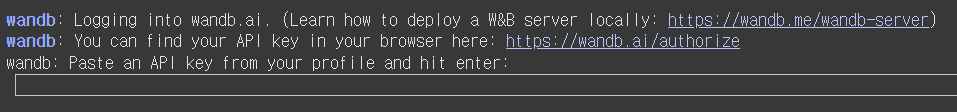  
두 번째로 나오는 링크로 들어가서 권한 획득을 위한 API key를 복사한 후, 입력창에 붙여넣습니다.

In [ ]:
run = wandb.init(
    config=hyperparameters,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork")
)
config = wandb.config
print(config)

set_seed(config.seed)

In [ ]:
save_dir = f"./save/dev_human_YS-{time.strftime('%b%d-%H-%M')}"
os.makedirs(save_dir)
add_file_handler(logger, save_dir + "/run.log")

## 2. 데이터 불러오기 및 전처리

### 2.1 `anndata` 패키지에 대한 이해

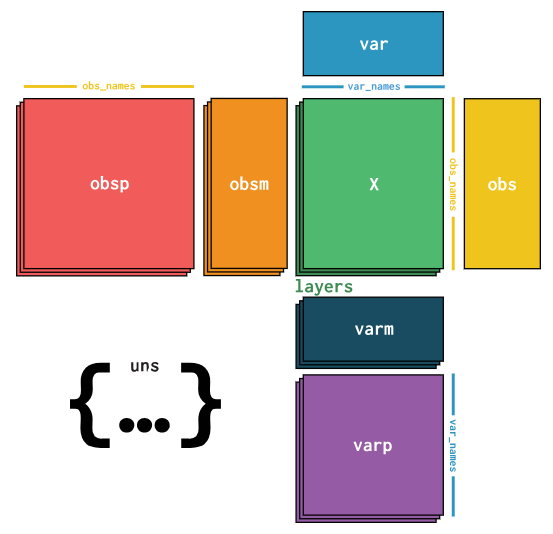

`anndata`는 각 행 및 열마다 annotation이 달려 있는 행렬 데이터를 간편하게 다룰 수 있도록 하는 Python 패키지로, gene expression 데이터를 저장하고 다루는 데에 많이 사용됩니다.  
이 라이브러리는 행렬 데이터를 `AnnData` 객체로 만들어주며, scRNA-seq 데이터를 담은 `AnnData` 객체는 아래와 같이 구성되어 있습니다.
- X: 원본 데이터
    - 행: observation, 각 cell을 나타냅니다.
    - 열: variable, 각 gene을 나타냅니다.
    - 값: 특정 cell의 특정 gene expression value를 나타냅니다.
- obs: observation에 대한 annotation, 즉 각 cell에 대한 metadata
- var: variable에 대한 annotation, 즉 각 gene에 대한 metadata

### 2.2 Human yolk sac 데이터 불러오기

이번 실습에 사용할 human yolk sac (YS) 데이터셋은 인간 수정란의 난황낭을 구성하는 세포들의 scRNA-seq 데이터입니다 ([Goh et al., *Science* 2023](https://www.science.org/doi/10.1126/science.add7564)). 데이터 구성은 아래와 같습니다.
- 10 YS samples: Carnegie stages 10-23
- 169,798 cells, 37,318 genes
- 38 cell subtypes

이번 실습에 사용할 데이터는 위 데이터 중 한 개의 샘플, 7,920개의 cell만 사용하겠습니다.

In [ ]:
# h5ad 형식으로 저장된 데이터셋을 확인해줍니다.
dataset_path = "./scGPT_dataset/celltype_cls/human_yolksac_train.h5ad"
test_dataset_path = "./scGPT_dataset/celltype_cls/human_yolksac_test.h5ad"

# scanpy.read_h5ad는 h5ad 파일을 읽어서 AnnData 객체로 만들어주는 역할을 합니다.
adata = sc.read_h5ad(dataset_path)
adata_test = sc.read_h5ad(test_dataset_path)
num_cells, num_genes = adata.shape
num_cells_test, num_genes_test = adata_test.shape

adata = adata[:(num_cells // 4), :]
adata_test = adata_test[:(num_cells_test // 4), :]

print("Train set")
print("X")
display(adata.to_df())
print("\nobs")
display(adata.obs)
print("\nvar")
display(adata.var)

**Label에 관하여**

`adata.obs`에는 cell type이 3가지의 level로 annotation된 데이터가 들어있습니다.  
Annotation level은 얼마나 세부적인 카테고리로 cell type을 나누었는지에 따라 구분되며, 각 level에서 상정한 cell type 카테고리는 아래 이미지와 같습니다.

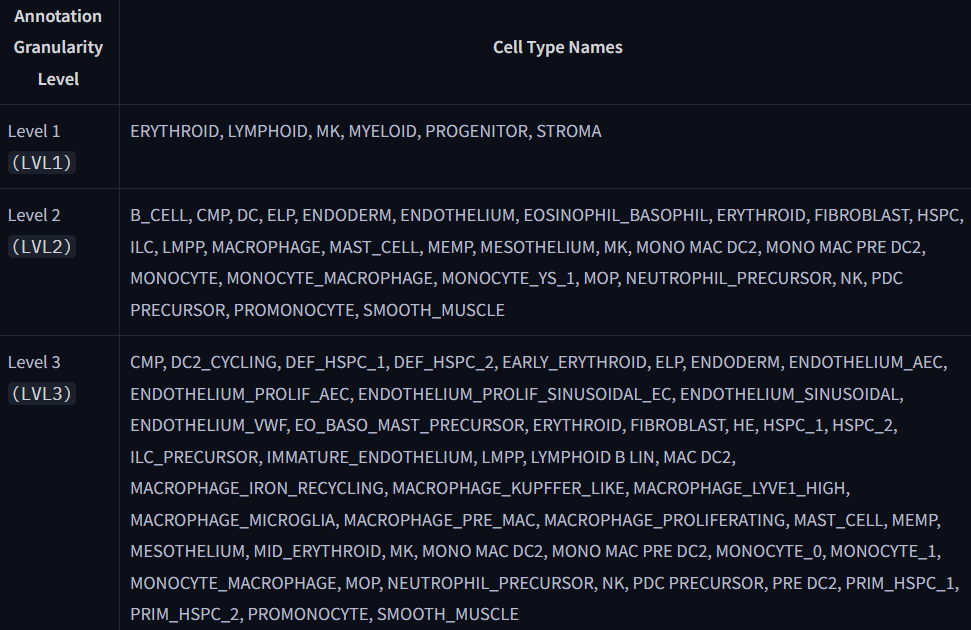

이번 실습에서는 6개의 카테고리로 cell type을 나눈 level 1 annotation을 label로 사용하겠습니다.


주어진 데이터를 모델 input으로 사용하기 위해 data type을 맞춰줍니다.

In [ ]:
## 코드 시작 ##
# 1. 각 batch(샘플)를 구분할 수 있는 구분자를 지정하여
# AnnData 객체의 obs metadata의 "str_batch" 칼럼에 설정해줍니다.
# 이번 실습 데이터는 한 명의 샘플을 다루기 때문에 batch ID를 아래와 같이 설정하겠습니다.
# Train set: 0, test set: 1

###################################
## 이 박스 위치에 코드를 작성해주세요 ##
###################################

# 2. adata.X의 칼럼명(adata.var의 index명)을 gene name으로 전환해줍니다.

###################################
## 이 박스 위치에 코드를 작성해주세요 ##
###################################

# 3. Train set과 test set을 하나의 AnnData 객체로 합쳐줍니다.
adata = None

# 4. Cell type ID와 cell type 이름을 mapping할 수 있는 딕셔너리를 만들어줍니다.
id2type = None
type2id = None

# 5. Batch 구분자와 cell type 레이블을 ID로 전환하여 AnnData 객체의 observation metadata에 설정해줍니다.
# 이 때, cell type ID는 obs metadata에 반드시 "celltype"이라는 칼럼명으로 저장하여야 합니다.
adata.obs["batch_id"] = None
adata.obs["celltype"] = None
## 코드 종료 ##

celltypes = adata.obs["LVL1"].unique()
num_types = len(np.unique(adata.obs["LVL1"].astype("category")))

### 2.3 Gene set cross-check

모델 사전학습에 사용한 gene set과 사용하려는 데이터셋의 gene set을 비교해줍니다.  
scGPT는 각 gene의 이름을 token으로 사용하기 때문에, 사전학습 모델의 vocab을 통해 사전학습에 사용한 gene set을 확인할 수 있습니다.

In [ ]:
vocab_path = "./scgpt/model/vocab.json"

# JSON 형태의 vocab 파일을 파이썬의 json 패키지로 열면
# 딕셔너리 객체로 vocab을 다룰 수 있습니다.
with open(vocab_path, 'r') as f:
    vocab = json.load(f)

# Vocab이 {"Gene 이름": index} 형태로 저장되어 있습니다.
print(vocab)

In [ ]:
# <pad>, <cls>, <eoc> 등 special token을 vocab에 추가해줍니다.
special_tokens = [config.pad_token, "<cls>", "<eoc>"]
for s in special_tokens:
    if s not in vocab:
        if s == config.pad_token:
            vocab[s] = config.pad_value
        else:
            vocab[s] = len(vocab)

# Human yolk sac 데이터셋의 gene 중 사전학습 vocab에 있는 gene과 없는 gene을 구분해줍니다.
adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])

logger.info(
    f"Vocab size: {len(vocab)}\n"
    f"데이터셋 내에 있는 gene 수: {len(gene_ids_in_vocab)}\n"
    f"데이터셋 내에 있는 gene 중 vocab에 있는 gene 수: {np.sum(gene_ids_in_vocab >= 0)}"
)

old_vocab = Vocab({token: i for i, token in enumerate(vocab)}, default_index=vocab["<pad>"])

### 2.4 데이터 전처리
Gene expression 데이터를 모델 input으로 넣기 위해 기본적인 전처리 과정(depth normalization, log normalization, highly variable gene (HVG) selection)을 거쳐줍니다.

소스 코드에 구현되어 있는 `scgpt.utils.preprocess.Preprocessor` 클래스를 사용할 예정입니다. `Preprocessor` 인스턴스를 초기화할 때 필요한 인자는 아래와 같습니다.

| 인자  | Type | 설명  
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `use_key` | `str` | 전처리 할 데이터 (RNA count)가 AnnData 객체의 어떤 layer에 저장되어 있는가 |
| `filter_gene_by_counts` | `int \| bool` | 모든 cell에 거쳐서 발현량이 매우 낮게 나타나는 gene을 필터링, count threshold를 입력할 수도 있고, False 입력 시 gene filtering 생략 |
| `filter_cell_by_counts` | `int \| bool` | 모든 gene에 거쳐서 발현량이 매우 낮게 나타나는 cell을 필터링, count threshold를 입력할 수도 있고, False 입력 시 cell filtering 생략 |
| `normalize_total` | `float \| bool` | Count normalization 후 총 count 합이 몇이 되도록 할 것인가, False 입력시 normalization 생략 |
| `result_normed_key` | `str \| None` | Normalized count를 AnnData 객체의 어떤 layer에 저장할 것인가, normalization 생략 시 None |
| `log1p` | `bool` | log1p transformation 수행 여부 |
| `result_log1p_key` | `str` | Log transformed count를 AnnData 객체의 어떤 layer에 저장할 것인가, log1p 생략 시 None |
| `subset_hvg` | `int \| bool` | HVG selection 수행 시 몇 개의 HVG를 선별할 지, False 입력 시 HVG selection 생략 |
| `hvg_flavor` | `Literal['seurat', 'cell_ranger', 'seurat_v3', 'seurat_v3_paper']` | HVG selection 시 사용할 프로토콜, HVG selection 생략 시 None |
| `binning` | `int` | scGPT에 발현량 정보를 입력할 때 몇 개의 bin으로 발현량을 나눠서 입력할 것인가 |
| `result_binned_key` | `str` | Binning을 수행한 데이터를 AnnData 객체의 어느 layer에 저장할 것인가 |

In [ ]:
# 전처리 옵션을 Preprocessor 클래스의 인자로 입력해준 후 전처리기 인스턴스를 만들어 줍니다.
preprocessor = Preprocessor(
    use_key="X",
    filter_gene_by_counts=False,
    filter_cell_by_counts=False,
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=True,
    result_log1p_key="X_log1p",
    subset_hvg=False,
    hvg_flavor=None,
    binning=config.n_bins,
    result_binned_key="X_binned",
)

# Train set과 test set을 나누어 전처리해줍니다.
adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]

# 생성된 preprocessor 객체로 아래와 같이 전처리를 수행할 수 있습니다.
# batch_key 인자는 observation metadata 중 batch 정보가 들어 있는 칼럼명을 나타냅니다.
# HVG selection에 사용되는 인자이므로, HVG selection 생략 시 None으로 입력합니다.
preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)

In [ ]:
# 전처리 후 데이터를 확인합니다.
print("Train set")
print("Normalized")
display(adata.to_df(layer="X_normed"))
print("Log transformed")
display(adata.to_df(layer="X_log1p"))
print("Binned")
display(adata.to_df(layer="X_binned"))

In [ ]:
print("Test set")
print("Normalized")
display(adata_test.to_df(layer="X_normed"))
print("Log transformed")
display(adata_test.to_df(layer="X_log1p"))
print("Binned")
display(adata_test.to_df(layer="X_binned"))

### 2.5 입력 데이터 토큰화 및 패딩
Gene expression을 언어 모델 입력으로 넣기 위해 gene 토큰화 및 패딩을 수행합니다.

언어모델에서 토큰화란 입력 문장이 주어졌을 때 그 문장을 vocab에 등록된 토큰으로 나누는 과정을 말합니다.

scGPT에서는 각 gene이 vocab이기 때문에 gene별로 토큰화가 수행될 예정입니다.

우선 train set 중 일부를 validation set으로 나누어줍니다.

In [ ]:
input_layer_key = config.input_layer_key
## 코드 시작 ##
## Train-validation split을 위해 필요한 정보를 준비합니다.

## 1. Input: 전처리를 수행한 gene expression values -> all_counts 변수에 저장합니다.
all_counts = None

## 2. Label: ID 형태의 cell type 정답값 -> NumPy array 형태로 celltypes_labels 변수에 저장합니다.
celltypes_labels = None

## 3. Batch ID: batch 구분자 -> NumPy array 형태로 batch_ids에 저장합니다.
batch_ids = None

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
) # Train-validation 비율을 달리 하려면 test_size 인자값을 변경해주면 됩니다.

In [ ]:
## 코드 시작 ##
## Test set에 대해서도 같은 방식으로 데이터를 준비해줍니다.
test_data = None
test_celltype_labels = None
test_batch_labels = None
## 코드 종료 ##

소스 코드에 제공되어 있는 `scgpt.utils.tokenizer.tokenize_and_pad_batch` 함수로 train set과 validation set에 대한 토큰화를 수행합니다. 해당 함수의 인자는 아래와 같습니다.

| 인자  | Type | 설명  
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `data` | `np.ndarray` | 토큰화할 입력 데이터 |
| `gene_ids` | `np.ndarray` | 각 gene의 ID 값이 담긴 NumPy array  |
| `max_len` | `int` | 최대 gene의 개수 |
| `vocab` | `scgpt.utils.tokenizer.Vocab` | 토큰화에 사용할 vocab |
| `pad_token` | `str` | Pad token은 어떻게 표현할 것인가 |
| `pad_value` | `str` | Pad token이 있는 자리는 ID를 어떻게 표현할 것인가 |
| `append_cls` | `bool` | CLS token (cell embedding)의 사용 여부 |
| `include_zero_gene` | `bool` | 발현량이 0으로 기록된 gene도 토큰화에 사용할 것인지 여부 |
| `cls_token` | `str` | CLS 토큰은 어떻게 표현할 것인가 |
| `return_pt` | `bool` | 토큰화된 데이터를 PyTorch tensor로 받을 것인지, False인 경우 NumPy array로 받음 |
| `mod_type` | `np.ndarray \| None` | Data modality를 ID값으로 나타낸 NumPy array, multiomic data integration에만 사용하므로, multioic task가 아닌 경우에는 None |
| `vocab_mod` | `scgpt.utils.tokenizer.Vocab \| None` | Modality token에 대한 vocab, multiomic data integration에만 사용하므로, multioic task가 아닌 경우에는 None |

CLS 토큰은 일련의 gene expression profile을 바탕으로 해당 cell에 대한 특성 정보가 함축된 임베딩 벡터를 만드는 토큰입니다.  
이 토큰으로부터 나온 임베딩 벡터는 cell type 분류를 위한 input으로 사용됩니다.

In [ ]:
# Vocab은 소스 코드에서 제공하는 scgpt.utils.tokenizer.Vocab 인스턴스로 만들어줍니다.

## 코드 시작 ##
## 사용하는 데이터셋에 있는 모든 gene과 special token을 vocab으로 등록합니다.
genes = None
total_token_set = None
## 코드 종료 ##

vocab = Vocab({token: i for i, token in enumerate(total_token_set)}, default_index=total_token_set.index("<pad>"))
gene_ids = np.array(list(map(lambda x: vocab.stoi[x], genes)), dtype=int)

In [ ]:
## 코드 시작 ##
## tokenize_and_pad_batch 함수에 적절한 인자를 넣어
## train set과 validation set에 대해 토큰화를 진행해줍니다.
## 힌트: None이 정답일 수도 있습니다.
tokenized_train = tokenize_and_pad_batch(
    data=None,
    gene_ids=None,
    max_len=None,
    vocab=None,
    pad_token=None,
    pad_value=None,
    append_cls=None,
    include_zero_gene=None,
    mod_type=None,
    vocab_mod=None
)

tokenized_valid = tokenize_and_pad_batch(
    data=None,
    gene_ids=None,
    max_len=None,
    vocab=None,
    pad_token=None,
    pad_value=None,
    append_cls=None,
    include_zero_gene=None,
    mod_type=None,
    vocab_mod=None
)

tokenized_test = tokenize_and_pad_batch(
    data=None,
    gene_ids=None,
    max_len=None,
    vocab=None,
    pad_token=None,
    pad_value=None,
    append_cls=None,
    include_zero_gene=None,
    mod_type=None,
    vocab_mod=None
)
## 코드 종료 ##

logger.info(
    f"Train set cell 수: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"Validation set cell 수: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

In [ ]:
# 토큰화 결과를 확인해줍니다
print(tokenized_train)
print(tokenized_valid)

## 3. 사전학습 된 scGPT 모델 사용하기

### 3.1 모델 불러오기

Gene expression prediction과 cell type annotation 등의 task를 수행하는 모델 architecture는 `TransformerModel`로 구현되어 있습니다. 해당 모델 세팅을 위해 필요한 인자는 아래와 같습니다.

| 인자  | Type | 설명  
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `ntoken` | `int` | 입력 데이터의 토큰 수 |
| `d_model` | `int` | 임베딩 벡터의 차원 수  |
| `nhead` | `int` | Multi-head attention 모듈에서 헤드 수 |
| `d_hid` | `int` | Transformer의 feed-forward layer에서 hidden dimension 수 |
| `nlayers` | `int` | Transformer encoder의 layer 수 |
| `nlayers_cls` | `int` | Classifier로 사용할 MLP의 layer 수 |
| `n_cls` | `int` | 예측하려는 class의 총 가짓수 |
| `vocab` | `scgpt.utils.tokenizer.Vocab` | 사용할 데이터에 따라 구축된 vocab |
| `dropout` | `float` | Transformer encoder에 있는 MLP layer에 대한 dropout 비율 |
| `pad_token` | `str` | Pad token이 어떻게 나타나있는지 |
| `pad_value` | `int` | Pad token에 대한 index |
| `do_mvc` | `bool` | Cell embedding에 대한 masked token prediction 수행 여부 |
| `do_dab` | `bool` | Domain adaptation을 위한 학습 여부 |
| `use_batch_labels` | `bool` | Batch label 사용 여부 |
| `num_batch_labels` | `int \| None` | Batch label 총 개수, batch label 미사용 시 None |
| `domain_spec_batchnorm` | `bool \| Literal['dsbn', 'batchnorm']` | Batch normalization을 수행하는 방식, domain-specific하게 할 것인지, 일반 batch norm을 적용할 것인지 선택 가능 |
| `input_emb_style` | `bool \| Literal['category', 'continuous', 'scaling']` | Embedding 값이 어떻게 구성되어있는지 입력 |
| `input_emb_style` | `Literal['category', 'continuous', 'scaling']` | Embedding 값이 어떻게 구성되어있는지 입력 |
| `cell_emb_style` | `Literal['cls', 'avg-pool', 'w-pool']` | Cell embedding을 어떤 방식으로 구성할지 입력 |
| `cell_emb_style` | `Literal['cls', 'avg-pool', 'w-pool']` | Cell embedding을 어떤 방식으로 구성할지 입력 |
| `mvc_decoder_style` | `Literal['inner_product', 'concat_query', 'sum_query']` | Gene expression prediction 시 Transformer decoder에서 query와 key간 attention 계산 방식 |
| `n_input_bins` | `str` | Input 데이터의 bin 개수 |
| `ecs_threshold` | `float` | ECS 수행 시 similarity threshold 값 |
| `explicit_zero_prob` | `float` | 확률적으로 특정 gene에 대한 발현량을 0으로 맞춰줄 것인지 여부 |
| `use_fast_transformer` | `bool` | 빠른 Transformer 연산을 위한 flash attention 사용 여부 |
| `fast_transformer_backend` | `Literal['linear', 'flash']` | 어떤 툴로 fast Transformer를 수행할지 |
| `pre_norm` | `bool` | LayerNorm을 self-attention 및 feed-forward 모듈 전에 적용할 것인지 여부 |

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
nlayers_cls = 3
input_emb_style = "continuous"
cell_emb_style = "cls"

## 코드 시작 ##
## 사용하려는 데이터에 맞게 적절한 인자를 입력하여 scGPT 모델을 초기화합니다.
## 힌트: 일부 인자는 앞선 hyperparameter 딕셔너리에 미리 세팅해 놓았습니다.
n_cls = None

## embsize와 d_hid는 같은 값으로 설정합니다.
embsize = None
d_hid = None
nlayers = None
nhead = None


model = TransformerModel(
    ntoken=None,
    d_model=None,
    nhead=None,
    d_hid=None,
    nlayers=None,
    nlayers_cls=None,
    n_cls=None,
    vocab=None,
    dropout=None,
    pad_token=None,
    pad_value=None,
    do_mvc=None,
    do_dab=None,
    use_batch_labels=None,
    num_batch_labels=None,
    domain_spec_batchnorm=None,
    input_emb_style=None,
    n_input_bins=None,
    cell_emb_style=None,
    explicit_zero_prob=None,
    use_fast_transformer=None,
    fast_transformer_backend="",
    pre_norm=None,
)
## 코드 종료 ##

모델 architecture를 초기화하였다면, 사전 학습된 모델의 파라미터를 `model` 인스턴스에 입혀, 사전학습된 scGPT를 사용할 수 있도록 세팅합니다.

In [ ]:
model_path = "./scgpt/model/best_model.pt"
try:
    model.load_state_dict(torch.load(model_path))
    logger.info(f"Loading all model params from {model_path}")
except:
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
model.to(device)

### 3.2 PyTorch DataLoader 인스턴스 만들기



딥 러닝 프레임워크인 PyTorch에서는 `torch.utils.data.DataLoader`를 이용해 학습을 위한 데이터를 순차적으로 모델에 입력합니다.  
DataLoader를 이용하면 학습 데이터를 mini-batch 단위로 쪼개어 모델에 입력하기 때문에, 학습에 사용되는 GPU 리소스를 보다 효율적으로 사용할 수 있습니다.

In [ ]:
# Step 1. Train, validation 데이터셋의 tokenized input, token index, label, batch ID를
# PyTorch 텐서로 불러오기
# 소스 코드의 prepare_data 함수로 이 작업을 수행할 수 있습니다.

train_data_pt, valid_data_pt = prepare_data(
    tokenized_train=tokenized_train,
    tokenized_valid=tokenized_valid,
    train_batch_labels=train_batch_labels,
    valid_batch_labels=valid_batch_labels,
    config=config,
    epoch=0,
    train_celltype_labels=train_celltype_labels,
    valid_celltype_labels=valid_celltype_labels,
)
print("Train data")
print(train_data_pt)
print("Validation data")
print(valid_data_pt)

In [ ]:
# 소스코드의 prepare_data의 프로세스를 그대로 따라하여
# Test set에 대한 input도 만들어줍니다.

input_values_test = random_mask_value(
    values=tokenized_test["values"],
    mask_ratio=config.mask_ratio,
    mask_value=config.mask_value,
    pad_value=config.pad_value
)

test_data_pt = {
    "gene_ids": tokenized_test["genes"],
    "values": input_values_test,
    "target_values": tokenized_test["values"],
    "batch_labels": torch.from_numpy(test_batch_labels).long(),
    "celltype_labels": torch.from_numpy(test_celltype_labels).long()
}

In [ ]:
# Step 2. 텐서 형식의 데이터를 PyTorch Dataset 객체로 만들기
# DataLoader를 만들기 위해서는 데이터를 Dataset 객체로 만들어야 합니다.
# 소스코드에는 scGPT input에 특화된 SeqDataset 객체를 통해 이를 만들 수 있습니다.

train_dataset = SeqDataset(train_data_pt)
valid_dataset = SeqDataset(valid_data_pt)
test_dataset = SeqDataset(test_data_pt)

In [ ]:
# Step 3. 데이터로더 만들기
# Train과 validation dataset에 대한 DataLoader를 만듭니다.
# DataLoader 인스턴스 생성 시 batch size를 지정할 수 있습니다.

train_dl = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
valid_dl = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
test_dl = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

### 3.3 사전학습 모델로 cell embedding 얻은 후 UMAP 분석하기


이 실습에서는 모델 fine-tuning 전후로 test set에 대한 cell embedding이 어떠한 차이가 있는지 비교하겠습니다.

우선 test set cell embedding을 얻은 후 한데 모아줍니다.

In [ ]:
# Mini-batch 별로 나오는 cell embedding을 아래 리스트에 모을 것입니다.
resulting_embeddings = []
labels = []
# 사전학습 모델을 그대로, 추가 학습 없이 사용할 것이기 때문에
# 파라미터 업데이트가 되지 않도록 torch.no_grad()를 설정해줍니다.
with torch.no_grad():
    for data_dict in tqdm(test_dl, desc="Cell embedding 얻는중"):
        input_gene_ids = data_dict["gene_ids"].to(device) # 모델이 GPU에 올라가 있다면 input 텐서도 GPU에 올려야 합니다
        src_key_padding_mask = input_gene_ids.eq(vocab[config.pad_token])

        embs = model._encode(
            src=input_gene_ids,
            values=data_dict["values"].to(device),
            src_key_padding_mask=src_key_padding_mask
        )

        cell_emb = model._get_cell_emb_from_layer(embs)
        resulting_embeddings.extend(cell_emb.cpu().numpy())
        labels.extend(data_dict["celltype_labels"])

한데 모은 cell embedding을 UMAP로 시각화하여 cell type 별로 cell embedding이 잘 분류되는지 확인하겠습니다.

In [ ]:
# UMAP 하이퍼파라미터를 세팅합니다
n_neighbors = 10
min_dist = 0.1
metric = "euclidean"

# UMAP으로 차원축소를 실행합니다.
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
umap_results = umap_reducer.fit_transform(resulting_embeddings)

unique_labels = list(id2type.values())
palette = sns.color_palette("hsv", len(id2type))
label_to_color = {id2type[i]: palette[i] for i in range(len(id2type))}


# UMAP 결과를 시각화합니다.
plt.figure(figsize=(10, 8))
for label in unique_labels:
    indices = np.where(np.array(labels) == torch.tensor(type2id[label]))[0]
    plt.scatter(umap_results[indices, 0], umap_results[indices, 1], s=5, alpha=0.7, label=label)
plt.legend(title="Cell types", loc="best", fontsize="small", markerscale=2)
plt.title("UMAP Visualization of scGPT cell embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


### 3.4 사전학습 모델로 얻은 cell embedding으로 cell type 분류하기

In [ ]:
test_labels = test_dl.dataset.data["celltype_labels"].tolist()
test_preds = []

with torch.no_grad():
    for emb in tqdm(resulting_embeddings, desc="Cell type 예측"):
        emb = torch.from_numpy(emb).to(device)
        pred = model.cls_decoder(emb)
        test_preds.append(pred.argmax().item())

print()
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.3f}")
print(f"Recall: {recall_score(test_labels, test_preds, average='macro'):.3f}")
print(f"Precision: {precision_score(test_labels, test_preds, average='macro'):.3f}")
print(f"F1 score: {f1_score(test_labels, test_preds, average='macro'):.3f}")

## 4. scGPT fine-tuning 하기


모델이 cell type annotation (classification) task에 더 최적화되도록 fine-tuning 합니다.

Transformer와 classifier만 추가로 학습하여 test set에 대해 cell type annotation 성능이 얼마나 증가했는지 확인합니다.

### 4.1 파라미터 freeze

Fine-tuning할 부분을 제외하고 나머지 모델 파라미터는 freeze합니다.

In [ ]:
# 전체 파라미터 개수를 카운트합니다.
pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Transformer와 classifier를 제외한 파라미터를 freeze합니다.
for name, para in model.named_parameters():
    print("-"*20)
    print(f"name: {name}")
    if config.freeze and "encoder" in name and "transformer_encoder" not in name:
        print(f"freezing weights for: {name}")
        para.requires_grad = False

# 파라미터 freeze 후 학습 가능한 파라미터를 카운트합니다.
post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")

model.to(device) # 모델을 GPU에 올립니다.
wandb.watch(model) # WandB가 모델 학습 사항을 모니터링 하도록 합니다.

### 4.2 모델 학습을 위한 요소 준비



모델 학습에 사용할 loss function, optimizer, learning rate scheduler를 준비합니다.

In [ ]:
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.lr,
    eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=1,
    gamma=config.schedule_ratio
)
scaler = torch.GradScaler(device, enabled=config.amp)

### 4.3 모델 학습 및 평가


앞선 세팅에 따라 모델을 fine-tuning 할 수 있는 training loop를 만듭니다.  
소스코드의 scgpt.utils.trainer에는 모델 학습 및 평가를 진행하는 `train`과 `evaluate` 함수, 그리고 test set에 대한 inference를 수행하는 `eval_testdata`*가* 구현되어 있습니다.

In [ ]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrics()

# Epoch 당 약 5분 소요
for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()

    if config.do_train:
        train(
            model=model,
            loader=train_dl,
            vocab=vocab,
            criterion_gep_gepc=None,
            criterion_dab=None,
            criterion_cls=criterion_cls,
            scaler=scaler,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            config=config,
            logger=logger,
            epoch=epoch,
        )
    val_loss = evaluate(
        model=model,
        loader=valid_dl,
        vocab=vocab,
        criterion_gep_gepc=None,
        criterion_dab=None,
        criterion_cls=criterion_cls,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), f"{save_dir}/model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            model = best_model,
            adata_t = adata_test,
            gene_ids = gene_ids,
            vocab = vocab,
            config = config,
            logger = logger,
            include_types=["cls"],
        )
        results["celltype_umap"].savefig(
            f"{save_dir}/embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/celltype_umap"] = wandb.Image(
            f"{save_dir}/embeddings_celltype_umap[cls]_e{best_model_epoch}.png",
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()
# 모델 실행 후 아래와 같은 에러가 발생한다면 무시합니다.
# Error: plotly is required to log interactive plots, install with: `pip install plotly` or convert the plot to an image with `wandb.Image(plt)`

In [ ]:
# 최적의 모델을 저장합니다.
torch.save(best_model.state_dict(), f"{save_dir}/best_model.pt")

In [ ]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = f"{save_dir}/best_model.pt"
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

# 실습 2. Multiomic data integration

실습 목표: Paired RNA-protein 데이터셋으로 fine-tuning하여 **gene expression 및 protein abundance를 예측**하고, 예측값을 바탕으로 **cell type에 따른 clustering 성능이 개선**되었는지 확인하기

차례
1. 하이퍼파라미터 세팅
1. 데이터 불러오기 및 전처리
1. 사전학습 된 scGPT 모델 사용하기
1. scGPT fine-tuning 하기

## 1. 하이퍼파라미터 세팅

Multiomic 데이터의 경우 cell type annotation과는 다른 fine-tuning objective를 가집니다. Multiomic task에 적합한 하이퍼파라미터를 세팅해줍니다.

하이퍼파라미터는 학습되는 파라미터가 아닌, 사용자가 직접 설정해 주어야 하는 값들을 의미합니다.

| 이름                 | Type                     | 설명                                                                       
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `seed`            | `int`                    | 모델 초기화 시드                                              |
| `do_train`           | `bool`                    | 학습을 통해 모델의 파라미터 업데이트 여부                                                                 |
| `load_model`              | `str`                    | 사전학습된 모델의 파라미터가 들어있는 모델 경로                                                       |
| `GEP`               | `bool`                    | Fine-tuning objective 1: gene expression prediction 여부                                             |
| `GEPC`              | `bool`                    | Fine-tuning objective 2: GEP for cell modeling 여부                                                             |
| `CLS`                | `bool`                    | Fine-tuning objective 3: cell type classification 여부                                                 |
| `ESC`              | `bool`                  | Fine-tuning objective 4: elastic cell similarity 여부                     |
| `DAR`         | `bool`                    | Fine-tuning objective 5: domain adaptation via reverse back propagation 여부                                                   |
| `DSBN`           | `bool`                    | Fine-tuning objective 6: domain-specific batch normalization 여부                                                   |
| `ecs_thres`            | `float \| int`                    | ECS task에서의 similarity threshold, ECS 미수행 시 0                                                 |
| `dab_weight`           | `float \| int`                    | Domain adaptation loss 비율                                                                 |
| `use_batch_labels`          | `bool`                   | Batch embedding 사용 여부                                                  |
| `use_mod`               | `bool` | Modality token 사용 여부, multi-modality input 사용 시 True                                            |
| `mask_ratio` | `float`                   | MLM에서 masking 비율                                                         |
| `explicit_zero_prob` | `bool`                   | 확률적으로 특정 gene에 대한 발현량을 0으로 맞춰줄 것인지 여부                                                         |
| `per_seq_batch_sample` | `bool`                   | 모델 학습을 위한 mini-batch를 만들 때, 한 mini-batch에는 같은 scRNA-seq batch로부터 나온 데이터로만 구성할지 여부                                                         |
| `epochs` | `int`                   | Training epoch 수                                                         |
| `input_layer_key` | `str`                   | AnnData 객체의 layer 중 model input으로 사용할 layer                                                         |
| `n_bins` | `int`                   | Value binning 기법에서 사용할 bin 수                                                         |
| `n_hvg` | `int` | 원본 데이터 중 HVG 몇 개만 선별하여 사용할 지 설정 |
| `max_seq_len` | `int` | Default n_hvg + 1 |
| `lr` | `float` | 학습률 |
| `batch_size` | `int` | Mini-batch 크기 |
| `layer_size` | `int` | Embedding vector의 dimension 수 |
| `nlayers` | `int` | Transformer 모델의 encoder layer 수 |
| `nhead` | `int` | Multi-head attention에서 사용할 head 수 |
| `dropout` | `float` | MLP에 적용할 dropout 비율 |
| `schedule_ratio` | `float` | 학습률 scheduler에 사용할 learning rate decay 비율 |
| `save_eval_interval` | `int` | 몇 epoch마다 학습된 파라미터를 파일로 저장할지 지정 |
| `log_interval` | `int` | 학습 상황 logging을 몇 mini-batch마다 할 것인지 지정 |
| `fast_transformer` | `bool` | FlashAttention 사용 여부 |
| `pre_norm` | `bool` | LayerNorm을 self-attention 및 feed-forward 모듈 전에 적용할 것인지 여부 |
| `amp` | `bool` | Mixed precision learning 적용 여부, 사용 시 연산 효율성과 학습 성능을 향상 |
| `pad_token` | `str` | Vocab에 pad token이 어떻게 저장되어있는지 작성 |
| `mask_value` | `int` | Mask token index |
| `pad_value` | `int` | Pad token index |
| `include_zero_gene` | `bool` | 발현량이 0인 gene도 포함할지 여부 |
| `freeze` | `bool` | Fine-tuning 시 인코더 freeze 여부 |

In [ ]:
hyperparameters = {
    "task": "multiomic",
    "seed": 42,
    "dataset_name": "BMMC",
    "do_train": True,
    "load_model": "./scgpt/model",
    ## 코드 시작 ##
    ## 아래 fine-tuning objective (GEP-DSBN) 중 이번 실습에서 사용할 objective를 boolean으로 표시해주세요.
    ## None 대신 각 기준에 올바른 값들을 넣어주세요
    "GEP": None,
    "GEPC": None,
    "CLS": None,
    "ESC": None,
    "DAR": None,
    "DSBN": None,
    "ecs_thres": None, # ECS가 fine-tuning objective인 경우 cell similarity threshold를 0.8로 지정해주고, objective가 아닌 경우 0으로 설정
    "dab_weight": None, # DAR이 fine-tuning objective인 경우 domain adaptation loss 적용 비율을 1.0으로 지정해주고, objective가 아닌 경우 0으로 설정
    "use_batch_labels": None,
    "use_mod": None,
    "mask_ratio": None, # Mask를 적용하려면 0.4로, 아니면 0으로 세팅합니다.
    ## 코드 종료 ##
    "explicit_zero_prob": False,
    "per_seq_batch_sample": False,
    "epochs": 2,
    "input_layer_key": "X_binned",
    "n_bins": 51,
    "n_hvg": 1200,
    "n_hvp": 4000,
    "max_seq_len": 4001,
    "lr": 1e-3,
    "batch_size": 16,
    "layer_size": 512,
    "nlayers": 4,
    "nhead": 8,
    "dropout": 0.2,
    "schedule_ratio": 0.95,
    "save_eval_interval": 5,
    "log_interval": 100,
    "fast_transformer": False,
    "pre_norm": False,
    "amp": True,
    "pad_token": "<pad>",
    "mask_value": -1,
    "pad_value": -2,
    "include_zero_gene": False,
}

In [ ]:
run = wandb.init(
    config=hyperparameters,
    project="scGPT2",
    reinit=True,
    settings=wandb.Settings(start_method="fork")
)
config = wandb.config
print(config)

set_seed(config.seed)

In [ ]:
# wandb를 통해 모델 학습 사항이 기록됨에 따라 이를 기록할 경로를 지정해줍니다.
save_dir = f"./save/dev_BMMC-{time.strftime('%b%d-%H-%M')}"
os.makedirs(save_dir)
add_file_handler(logger, save_dir + "/run.log")

## 2. 데이터 불러오기 및 전처리

### 2.1 BMMC dataset 불러오기

Bone marrow mononuclear cell (BMMC) dataset란 CITE-seq으로 측정한 gene expression 및 protein abundance 데이터셋입니다. ([Luecken et al., *NeurIPS* 2021](https://openreview.net/forum?id=gN35BGa1Rt))  
Paired dataset이기 때문에 모든 cell에 대해 gene expression과 protein abundance가 모두 주어져 있습니다.  
데이터셋 구성은 아래와 같습니다.
- 12 donors: healthy samples, 한 샘플당 batch 1개로 총 12 batches
- 90,261 cells
- 13,953 genes, 134 surface proteins
- 45 immune cell subtypes

이번 예시 코드에서는 시간 단축을 위해 3명의 샘플, 12,000개의 cell, 17가지의 cell subtype (B cell, T cell, monocyte)만 사용할 예정입니다.

In [ ]:
# h5ad 형식으로 저장된 데이터셋을 확인해줍니다.
dataset_path = "./scGPT_dataset/multiomics/BMMC_processed.h5ad"

adata = sc.read_h5ad(dataset_path)
print("X")
display(adata.to_df())
print("obs")
display(adata.obs)
print("var")
display(adata.var)

In [ ]:
adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype("category")
adata.var["gene_name"] = adata.var.index.tolist()

In [ ]:
# Batch(샘플) 이름을 ID 값으로 전환해줍니다.
le = preprocessing.LabelEncoder()
encoded_batch = le.fit_transform(adata.obs["batch"].values)
adata.obs["batch_id"] = encoded_batch
adata.obs["str_batch"] = adata.obs["batch_id"].astype("category")

## 코드 시작 ##
# Gene expression 데이터와 protein abundance 데이터를 구분하여 저장해 줍니다.
# Expression에 대한 metadata에 gene expression은 GEX로, protein abundance는 ADT(antibody-derived tags)로 표시되어 있습니다.
adata_protein = None

# adata_protein의 index는 기존의 gene index 이름 앞에 "p_"를 붙여 지정해줍니다.
# ex> CD86 -> p_CD86

###################################
## 이 박스 위치에 코드를 작성해주세요 ##
###################################

# 나머지 gene expression은 adata 변수에 저장해줍니다.
adata = None
## 코드 종료 ##

# 별도의 Pandas DataFrame에 data modality에 대한 정보를 저장해줍니다.
gene_rna_df = pd.DataFrame(index=adata.var.index.tolist())
gene_rna_df["mod"] = "RNA"
gene_protein_df = pd.DataFrame(index=adata_protein.var.index.tolist())
gene_protein_df["mod"] = "Protein"
gene_loc_df = pd.concat([gene_rna_df, gene_protein_df])
gene_loc_df["mod"] = gene_loc_df["mod"].astype("category")

### 2.2 Gene set cross-check
모델 사전학습에 사용한 gene set과 사용하려는 데이터셋의 gene set을 비교해줍니다.

In [ ]:
vocab_file = "./scgpt/model/vocab.json"

with open(vocab_file, 'r') as f:
    vocab = json.load(f)

# <pad>, <eoc> 등 special token을 vocab에 추가해줍니다.
max_vocab_idx = max(list(vocab.values()))
for s in special_tokens:
    if s not in vocab:
        max_vocab_idx += 1
        vocab[s] = max_vocab_idx

# BMMC 데이터셋의 gene 중 사전학습 vocab에 있는 gene과 없는 gene을 구분해줍니다.
adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])

logger.info(
    f"Vocab size: {len(vocab)}\n"
    f"데이터셋 내에 있는 gene 수: {len(gene_ids_in_vocab)}\n"
    f"데이터셋 내에 있는 gene 중 vocab에 있는 gene 수: {np.sum(gene_ids_in_vocab >= 0)}"
)

old_vocab = Vocab({token: i for i, token in enumerate(vocab)}, default_index=vocab["<pad>"])

### 2.3 데이터 전처리

이 실습에서는 scRNA-seq과 protein의 multi-modal 데이터를 다루기 때문에 RNA 데이터와 protein 데이터에 대해 각각 별도의 전처리를 거쳐줍니다.

In [ ]:
# scRNA-seq 데이터에 대한 전처리를 수행합니다.
preprocessor_rna = Preprocessor(
    use_key='X',
    filter_gene_by_counts=1,
    filter_cell_by_counts=1,
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=False,
    result_log1p_key=None,
    subset_hvg=config.n_hvg,
    hvg_flavor="cell_ranger",
    binning=config.n_bins,
    result_binned_key="X_binned"
)

preprocessor_rna(adata, batch_key=None)

In [ ]:
preprocessor_prot = Preprocessor(
    use_key='X',
    filter_gene_by_counts=0,
    filter_cell_by_counts=False,
    normalize_total=False,
    result_normed_key=None,
    log1p=False,
    result_log1p_key=None,
    subset_hvg=False,
    hvg_flavor=None,
    binning=config.n_bins,
    result_binned_key="X_binned"
)

preprocessor_prot(adata_protein, batch_key=None)

In [ ]:
# 전처리 된 두 데이터를 합쳐줍니다.
data_combined = np.concatenate([adata.layers["X_binned"], adata_protein.layers["X_binned"]], axis=1)
adata = AnnData(
    X=data_combined,
    obs=adata.obs,
    var=pd.DataFrame(index=adata.var_names.tolist() + adata_protein.var_names.tolist()),
    layers={"X_binned": data_combined,}
)
adata.var["gene_name"] = adata.var.index.tolist()

### 2.4 입력 데이터 토큰화 및 패딩

In [ ]:
## 코드 시작 ##
## 토큰화를 위해 필요한 데이터를 준비하는 코드를 작성하세요
input_layer_key = None
all_counts = None
genes = None

celltypes_labels = None
num_types = None
celltypes_labels = None

batch_ids = None
num_batch_types = None
batch_ids = None
## 코드 종료 ##

Multiomic data integration task에서는 데이터의 modality를 구분해주는 modality token이 추가로 들어가게 됩니다.

Modality token은 modality type, 즉 gene expression(GEX)인지 protein abundance(ADT)인지를 구분해주기 때문에, 데이터에 있는 modality type을 vocab으로 사용합니다.

In [ ]:
## 코드 시작 ##
## Modality token을 vocab에 추가하는 코드를 작성합니다.
## 1.  각 gene 혹은 protein 별 modality가 무엇인지 리스트업하여 NumPy array 형태로 저장합니다.
mod_type = None

## 2. Modality vocab을 구축 후 Vocab 객체로 만들어줍니다.
vocab_mod = None

## 3. 각 gene 혹은 protein 별 modality를 ID로 전환하여 NumPy array 형태로 저장합니다.
mod_type = None

## 4. ntoken_mod 변수에 modality token 총 개수를 저장합니다.
ntokens_mod = None
## 코드 종료 ##

이번에도 입력 데이터를 train set과 validation set으로 나눕니다.

In [ ]:
## 코드 시작 ##
## train_test_split 함수로 데이터셋을 train set과 validatin set으로 나눕니다.
(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(None)
## 코드 종료 ##

scGPT는 gene 단위의 input으로 사전학습된 모델인 만큼, multiomic data input이 들어오면 gene과는 다른 modality의 feature가 토큰으로 들어오게 됩니다.  
따라서 모델이 새롭게 input으로 받은 토큰, 즉 protein을 vocab으로 등록하여, 새 토큰에 대한 의미를 학습할 수 있도록 해야 합니다.

In [ ]:
## 코드 시작 ##
## 사용하는 데이터에 존재하는 모든 gene을 vocab으로 등록해줍니다.
pretrained_genes = None
new_genes = None
## 사전학습 된 gene들을 ID 값으로 전환 후 NumPy array 형태로 저장합니다.
gene_ids_pretrained = None

total_gene_set = None

## vocab은 Vocab 객체로 만들어줍니다.
vocab = None

## 모든 gene을 ID 값으로 전환 후 NumPy array 형태로 저장합니다.
gene_ids = None
## 코드 종료 ##

`tokenize_and_pad_batch` 함수로 train set과 validation set에 대한 토큰화를 수행합니다. 해당 함수의 인자는 아래와 같습니다.

| 인자  | Type | 설명  
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `data` | `np.ndarray` | 토큰화할 입력 데이터 |
| `gene_ids` | `np.ndarray` | 각 gene의 ID 값이 담긴 NumPy array  |
| `max_len` | `int` | 최대 gene의 개수 |
| `vocab` | `scgpt.utils.tokenizer.Vocab` | 토큰화에 사용할 vocab |
| `pad_token` | `str` | Pad token은 어떻게 표현할 것인가 |
| `pad_value` | `str` | Pad token이 있는 자리는 ID를 어떻게 표현할 것인가 |
| `append_cls` | `bool` | CLS token (cell embedding)의 사용 여부 |
| `include_zero_gene` | `bool` | 발현량이 0으로 기록된 gene도 토큰화에 사용할 것인지 여부 |
| `cls_token` | `str` | CLS 토큰은 어떻게 표현할 것인가 |
| `return_pt` | `bool` | 토큰화된 데이터를 PyTorch tensor로 받을 것인지, False인 경우 NumPy array로 받음 |
| `mod_type` | `np.ndarray \| None` | Data modality를 ID값으로 나타낸 NumPy array, multiomic data integration에만 사용하므로, multioic task가 아닌 경우에는 None |
| `vocab_mod` | `scgpt.utils.tokenizer.Vocab \| None` | Modality token에 대한 vocab, multiomic data integration에만 사용하므로, multioic task가 아닌 경우에는 None |

In [ ]:
## 코드 시작 ##
## Train set과 validation set에 대해 토큰화합니다.
tokenized_train = tokenize_and_pad_batch(None)
tokenized_valid = tokenize_and_pad_batch(None)
## 코드 종료 ##

logger.info(
    f"Train set 샘플 개수: {tokenized_train['genes'].shape[0]},"
    f"feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"Validation set 샘플 개수: {tokenized_valid['genes'].shape[0]},"
    f"Feature length: {tokenized_valid['genes'].shape[1]}"
)

print(tokenized_train)
print(tokenized_valid)

## 3. 사전학습 된 scGPT 모델 불러온 후 fine-tuning 하기

### 3.1 모델 불러오기

Multiomic task를 위한 모델은 multimodal data input에 특화된 `MultiOmicTransformerModel`로 구현되어 있습니다. 해당 모델 세팅을 위해 필요한 인자는 아래와 같습니다.

| 인자  | Type | 설명  
|------------------------|--------------------------|----------------------------------------------------------------------------|
| `ntoken` | `int` | 입력 데이터의 토큰 수 |
| `d_model` | `int` | 임베딩 벡터의 차원 수  |
| `nhead` | `int` | Multi-head attention 모듈에서 헤드 수 |
| `d_hid` | `int` | Transformer의 feed-forward layer에서 hidden dimension 수 |
| `nlayers` | `int` | Transformer encoder의 layer 수 |
| `nlayers_cls` | `int` | Classifier로 사용할 MLP의 layer 수 |
| `n_cls` | `int` | 예측하려는 class의 총 가짓수 |
| `vocab` | `scgpt.utils.tokenizer.Vocab` | 사용할 데이터에 따라 구축된 vocab |
| `dropout` | `float` | Transformer encoder에 있는 MLP layer에 대한 dropout 비율 |
| `pad_token` | `str` | Pad token이 어떻게 나타나있는지 |
| `pad_value` | `int` | Pad token에 대한 index |
| `do_mvc` | `bool` | Cell embedding에 대한 masked token prediction 수행 여부 |
| `do_dab` | `bool` | Domain adaptation을 위한 학습 여부 |
| `use_batch_labels` | `bool` | Batch label 사용 여부 |
| `num_batch_labels` | `int \| None` | Batch label 총 개수, batch label 미사용 시 None |
| `domain_spec_batchnorm` | `bool \| Literal['dsbn', 'batchnorm']` | Batch normalization을 수행하는 방식, domain-specific하게 할 것인지, 일반 batch norm을 적용할 것인지 선택 가능 |
| `input_emb_style` | `bool \| Literal['category', 'continuous', 'scaling']` | Embedding 값이 어떻게 구성되어있는지 입력 |
| `cell_emb_style` | `Literal['cls', 'avg-pool', 'w-pool']` | Cell embedding을 어떤 방식으로 구성할지 입력 |
| `mvc_decoder_style` | `Literal['inner_product', 'concat_query', 'sum_query']` | Gene expression prediction 시 Transformer decoder에서 query와 key간 attention 계산 방식 |
| `n_input_bins` | `str` | Input 데이터의 bin 개수 |
| `ecs_threshold` | `float` | ECS 수행 시 similarity threshold 값 |
| `explicit_zero_prob` | `float` | 확률적으로 특정 gene에 대한 발현량을 0으로 맞춰줄 것인지 여부 |
| `use_fast_transformer` | `bool` | 빠른 Transformer 연산을 위한 flash attention 사용 여부 |
| `fast_transformer_backend` | `Literal['linear', 'flash']` | 어떤 툴로 fast Transformer를 수행할지 |
| `pre_norm` | `bool` | LayerNorm을 self-attention 및 feed-forward 모듈 전에 적용할 것인지 여부 |
| `use_mod` | `bool` | Multimodal input 사용 여부 |
| `ntokens_mod` | `int \| None` | Modality token 총 개수, multimodal input 미사용 시 None |
| `vocab_mod` | `Vocab \| None` | Modality token vocab |

In [ ]:
## 코드 시작 ##
## Multiomic task를 위한 모델을 초기화합니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
model_dict = torch.load("./scgpt/model/best_model.pt")

ntokens = None
embsize = None
nhead = None
nlayers = None
d_hid = None

model = MultiOmicTransformerModel(None)
## 코드 종료 ##

## 사전 학습된 모델의 파라미터를 불러옵니다.
with torch.no_grad():
    pretrained_emb_weights = model_dict['encoder.embedding.weight'][gene_ids_pretrained, :]
    model.encoder.embedding.weight.data[:len(pretrained_genes), :] = pretrained_emb_weights
    model.encoder.enc_norm.weight.data = model_dict['encoder.enc_norm.weight']

model.to(device)
print(model)

Multiomics task에서는 모델의 모든 파라미터를 fine-tuning할 예정입니다. 따라서 일부 파라미터를 freeze하는 과정은 생략하겠습니다.

### 3.2 모델 학습을 위한 요소 준비

모델 학습에 사용할 loss function, optimizer, learning rate scheduler를 준비합니다.

In [ ]:
# MLM MSE loss에 사용할 loss function을 정의합니다.
def masked_mse_loss(input, target, mask):
    mask = mask.float()
    loss = F.mse_loss(input * mask, target * mask, reduction="sum")

    return loss / mask.sum()

criterion_gep_gepc = masked_mse_loss

In [ ]:
# Domain adaptation을 위해 cross entropy loss를 사용합니다.
criterion_dab = nn.CrossEntropyLoss()

# Optimizer와 scheduler를 정의합니다.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.lr,
    eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=1,
    gamma=config.schedule_ratio
)
scaler = torch.GradScaler(device, enabled=config.amp)

앞선 task와 동일한 방식으로 `prepare_data` 함수로 텐서를 만들고, `SeqDataset` 인스턴스를 만들어준 뒤, `DataLoader` 인스턴스를 만들어줍니다.

### 3.3 PyTorch DataLoader 인스턴스 만들고, 모델 학습 및 평가하기

Multiomic task에는 gene expression prediction을 수반하기 때문에 training epoch이 한 번 진행될 때마다 token random masking이 이루어집니다.  
이에 따라 서로 다른 토큰이 mask 토큰으로 대체되기 때문에 그 때마다 DataLoader를 새로 정의해 주어야 합니다.

Training loop 내부에서 random masking 및 DataLoader 인스턴스 생성을 실습하겠습니다.

In [ ]:
## 코드 시작 ##
## 토큰화된 데이터를 텐서 형태로 변환한 후 그 형태를 확인해줍니다.
## 이 코드는 모델 학습에 필수적으로 필요한 코드는 아니며,
## cell type annotation에 사용되는 input과 형태가 어떻게 다른지 확인하기 위해 추가한 코드입니다.
## 힌트: epoch은 아무 정수나 입력해도 좋습니다.
train_data_pt, valid_data_pt = prepare_data(None)

print(train_data_pt)
## 앞선 실습과 다르게 mod_types라는 key에 modality token이 추가되어 있음을 확인할 수 있습니다.
## 코드 종료 ##

In [ ]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    ## 코드 시작 ##
    ## 1. Training loop 내부에서 데이터를 텐서 형태로 변환한 후
    ##    DataLoader 인스턴스를 만들어 줍니다.

    ## 앞선 실습에서 사용한 prepare_data 함수를 사용하면
    ## 내부적으로 random masking을 수행한 train 및 validation 데이터를 내보내줍니다.
    train_data_pt, valid_data_pt = prepare_data(None)

    train_dataset = None
    valid_dataset = None

    train_dl = None
    valid_dl = None

    ## 2. train 함수로 train set에 대해 모델을 학습시키고,
    ##    evaluate 함수로 validation set에 대해 성능을 확인합니다.
    ##    그리고 validation set에서 가장 성능이 좋았던 training epoch과 모델을
    ##    각각 best_model 변수와 best_model_epoch 변수에 저장합니다.
    if config.do_train:
        ###################################
        ## 이 박스 위치에 코드를 작성해주세요 ##
        ###################################
    val_loss = None
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    ## 3. Validation set에 대해 제일 성능이 좋았던 모델과 epoch을 기록해둡니다.

    ###################################
    ## 이 박스 위치에 코드를 작성해주세요 ##
    ###################################

    ## 코드 종료 ##

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        ## 코드 시작 ##
        ## Validation set에 대해 제일 성능이 좋았던 모델을 저장합니다.
        torch.save(None)

        # Test dataset에 대한 평가를 수행합니다.
        results = None
        ## 코드 종료 ##

        results["batch_umap"].savefig(
            save_dir + f"/embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir + f"/embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            save_dir + f"/embeddings_batch_umap[cls]_e{best_model_epoch}.png",
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            save_dir + f"/embeddings_celltype_umap[cls]_e{best_model_epoch}.png",
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [ ]:
# Validation set에 대해 최적의 성능이 나온 모델의 파라미터를 저장합니다.
torch.save(best_model.state_dict(), f"{save_dir}/best_model.pt")

In [ ]:
# 모델의 학습 로그와 최적의 모델을 artifact로 기록합니다.
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

정답 코드: https://github.com/KU-MedAI/KSBI_BIML_2025_workshop